# Prepares environment and loads required libraries.

In [ ]:
# basic imports and a quick check of what files are in the data folder
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set a seed so results don't jump around too much
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# checking what datasets I actually have locally
data_dir = Path("data")
if not data_dir.exists():
    raise SystemExit("expected a data/ folder with the CSV inside")

csv_files = sorted(list(data_dir.rglob("*.csv")))
parquet_files = sorted(list(data_dir.rglob("*.parquet")))
all_files = csv_files + parquet_files

print(f"found {len(all_files)} file(s) under data/")
for f in all_files:
    print(" -", f)

# take a quick look at the first CSV to confirm column names
if csv_files:
    sample_path = csv_files[0]
    df_preview = pd.read_csv(sample_path, nrows=5)
    print("\npreview from:", sample_path)
    print("columns:", list(df_preview.columns))
    display(df_preview)
else:
    # fallback if only parquet exists
    sample_path = parquet_files[0]
    df_preview = pd.read_parquet(sample_path).head(5)
    print("\npreview from:", sample_path)
    print("columns:", list(df_preview.columns))
    display(df_preview)

found 14 file(s) under data/
 - data/AEP_hourly.csv
 - data/COMED_hourly.csv
 - data/DAYTON_hourly.csv
 - data/DEOK_hourly.csv
 - data/DOM_hourly.csv
 - data/DUQ_hourly.csv
 - data/EKPC_hourly.csv
 - data/FE_hourly.csv
 - data/NI_hourly.csv
 - data/PJME_hourly.csv
 - data/PJMW_hourly.csv
 - data/PJM_Load_hourly.csv
 - data/pjm_hourly_est.csv
 - data/pjm_processed_features.csv

preview from: data/AEP_hourly.csv
columns: ['Datetime', 'AEP_MW']


,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


# Loads dataset, cleans data, and inspects structure.

In [ ]:
# loading the full dataset I'll work with for the forecasting part
df = pd.read_csv("data/AEP_hourly.csv")

# making the column names easy to reference
df.columns = [c.strip() for c in df.columns]

# converting timestamp column to proper datetime type
df["Datetime"] = pd.to_datetime(df["Datetime"])

# setting datetime as index since the model will treat it as a time series
df = df.set_index("Datetime").sort_index()

# making sure the data is hourly and filling any short gaps
df = df.resample("H").mean()
df["AEP_MW"] = df["AEP_MW"].ffill()

# quick sanity checks
print("shape:", df.shape)
print("time range:", df.index.min(), "to", df.index.max())
print("number of missing values:", df["AEP_MW"].isna().sum())

# taking a quick look at the first few rows after cleaning
df.head()

shape: (121296, 1)
time range: 2004-10-01 01:00:00 to 2018-08-03 00:00:00
number of missing values: 0


/var/folders/yw/7nv526h96y59_0vhdnlch9k80000gn/T/ipykernel_99419/2792831722.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").mean()


,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


# Creates time-series train/validation/test splits.

In [ ]:
# creating proper train/val/test splits for a time series
# using a simple time-based cutoff

series = df["AEP_MW"].astype(float)

# splitting 80% / 10% / 10%
n = len(series)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

train_series = series.iloc[:train_end]
val_series = series.iloc[train_end:val_end]
test_series = series.iloc[val_end:]

print("train:", train_series.shape)
print("val:  ", val_series.shape)
print("test: ", test_series.shape)

# window parameters
window_size = 24
horizon = 1

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_series.values.reshape(-1,1)).reshape(-1)
val_scaled   = scaler.transform(val_series.values.reshape(-1,1)).reshape(-1)
test_scaled  = scaler.transform(test_series.values.reshape(-1,1)).reshape(-1)

# function to make windows (same logic used in the utils)
def make_windows(arr, w, h=1):
    X, y = [], []
    max_start = len(arr) - w - (h - 1)
    for i in range(max_start):
        X.append(arr[i:i+w])
        y.append(arr[i+w+(h-1)])
    return np.array(X).reshape(-1, w, 1), np.array(y)

# applying windowing
X_train, y_train = make_windows(train_scaled, window_size, horizon)
X_val, y_val     = make_windows(val_scaled,   window_size, horizon)
X_test, y_test   = make_windows(test_scaled,  window_size, horizon)

print("windowed shapes:")
print(" X_train:", X_train.shape)
print(" X_val:  ", X_val.shape)
print(" X_test: ", X_test.shape)

train: (97036,)
val:   (12130,)
test:  (12130,)
windowed shapes:
 X_train: (97012, 24, 1)
 X_val:   (12106, 24, 1)
 X_test:  (12106, 24, 1)


# Builds and trains baseline LSTM model.

In [ ]:
# baseline LSTM model on the train/val split

from electricity_forecast_utils import build_lstm_model, train_model

# each sample has 24 time steps and 1 feature
input_shape = (X_train.shape[1], X_train.shape[2])

# starting with a fairly standard size for this dataset
model = build_lstm_model(
    input_shape=input_shape,
    units=64,
    dropout=0.1,
    lr=1e-3,
)

# train with early stopping on validation loss
history = train_model(
    model,
    X_train, y_train,
    X_val, y_val,
    epochs=30,
    batch_size=64,
    patience=5,
)

# checking how the loss evolved near the end of training
print("last 5 train losses:", history.history["loss"][-5:])
print("last 5 val losses:  ", history.history["val_loss"][-5:])

Epoch 1/30
1516/1516 - 8s - 5ms/step - loss: 0.0038 - mae: 0.0422 - val_loss: 6.6221e-04 - val_mae: 0.0195
Epoch 2/30
1516/1516 - 7s - 5ms/step - loss: 8.3133e-04 - mae: 0.0222 - val_loss: 3.1309e-04 - val_mae: 0.0136
Epoch 3/30
1516/1516 - 7s - 4ms/step - loss: 5.7128e-04 - mae: 0.0181 - val_loss: 3.1146e-04 - val_mae: 0.0129
Epoch 4/30
1516/1516 - 7s - 4ms/step - loss: 4.8400e-04 - mae: 0.0165 - val_loss: 2.5275e-04 - val_mae: 0.0116
Epoch 5/30
1516/1516 - 7s - 4ms/step - loss: 4.3310e-04 - mae: 0.0156 - val_loss: 2.3903e-04 - val_mae: 0.0114
Epoch 6/30
1516/1516 - 7s - 5ms/step - loss: 3.9767e-04 - mae: 0.0149 - val_loss: 2.6369e-04 - val_mae: 0.0118
Epoch 7/30
1516/1516 - 7s - 4ms/step - loss: 3.7104e-04 - mae: 0.0145 - val_loss: 2.2198e-04 - val_mae: 0.0109
Epoch 8/30
1516/1516 - 7s - 4ms/step - loss: 3.5430e-04 - mae: 0.0140 - val_loss: 2.1277e-04 - val_mae: 0.0109
Epoch 9/30
1516/1516 - 7s - 4ms/step - loss: 3.2985e-04 - mae: 0.0135 - val_loss: 2.0404e-04 - val_mae: 0.0105
Epoch

# Evaluates baseline model and examines test performance.

379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
TEST MAE:  122.474
TEST RMSE: 163.941


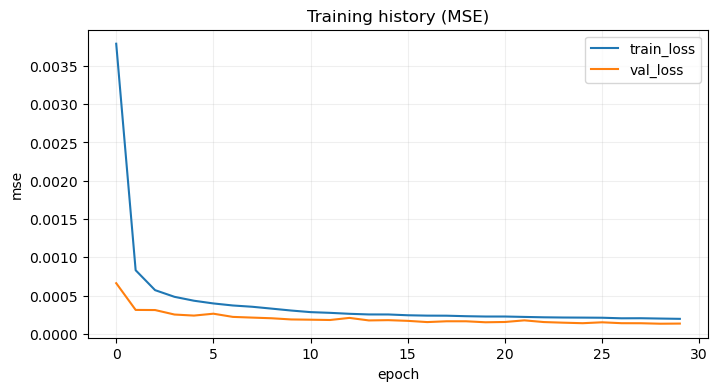

train loss (last): 0.00019649503519758582 val loss (last): 0.00013473966100718826


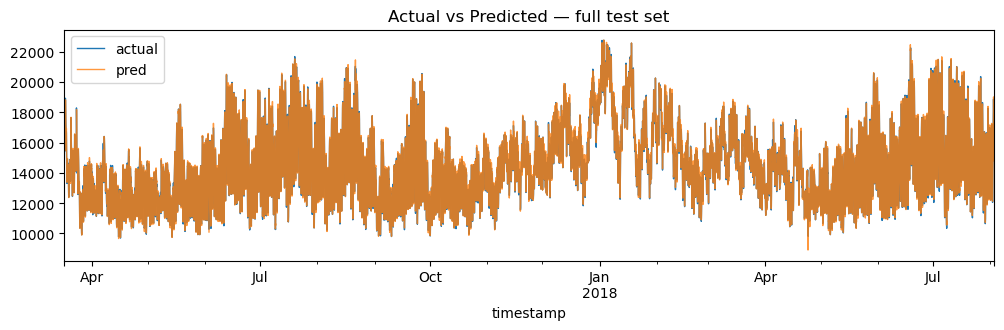

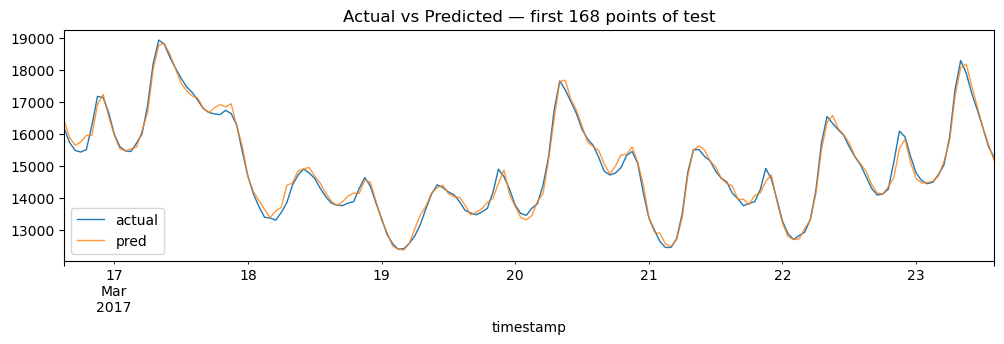

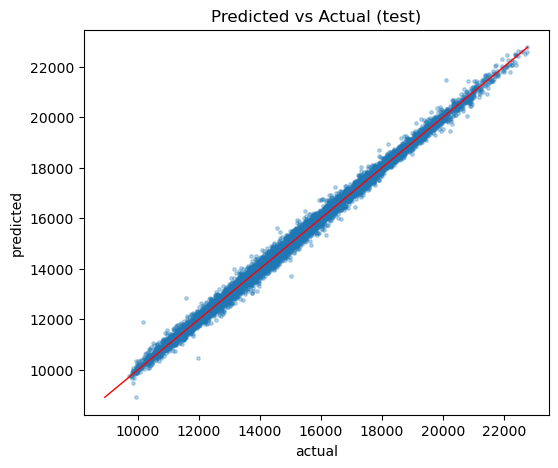

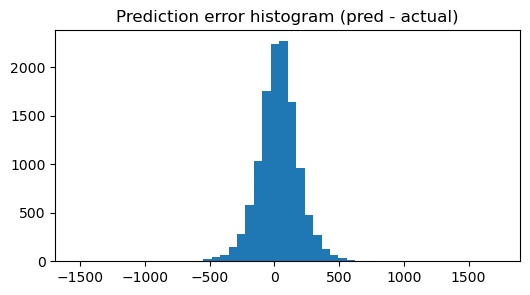

,actual,pred,abs_error
timestamp,,,
2017-03-16 15:00:00,16167.0,16411.494141,244.494141
2017-03-16 16:00:00,15723.0,15878.560547,155.560547
2017-03-16 17:00:00,15476.0,15635.193359,159.193359
2017-03-16 18:00:00,15429.0,15746.041016,317.041016
2017-03-16 19:00:00,15505.0,15948.442383,443.442383
2017-03-16 20:00:00,16268.0,15946.801758,321.198242
2017-03-16 21:00:00,17166.0,16912.740234,253.259766
2017-03-16 22:00:00,17132.0,17229.042969,97.042969
2017-03-16 23:00:00,16660.0,16546.824219,113.175781


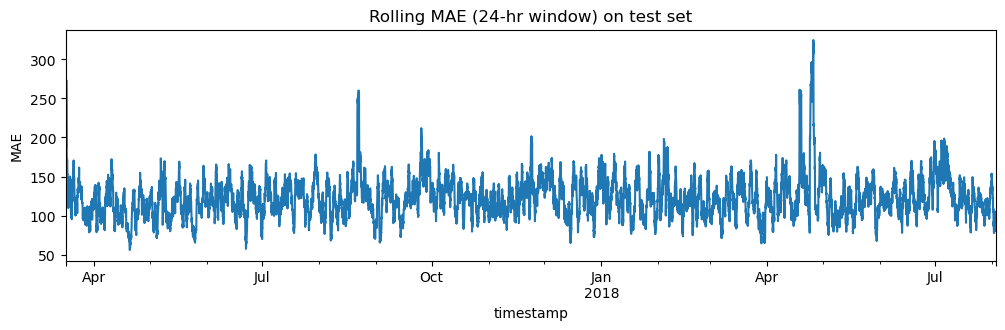

,test
MAE,122.473974
RMSE,163.941348
median_error,33.017578
std_error,160.928342


In [ ]:
# Evaluation and diagnostics on the test set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from electricity_forecast_utils import invert_and_eval

# 1) Predict on test set (scaled), invert scale to real units
y_test_pred_scaled = model.predict(X_test).reshape(-1)
y_test_true_scaled = y_test.reshape(-1)

y_test_true, y_test_pred, mae_test, rmse_test = invert_and_eval(y_test_true_scaled, y_test_pred_scaled, scaler)

print(f"TEST MAE:  {mae_test:.3f}")
print(f"TEST RMSE: {rmse_test:.3f}")

# 2) Plot training / validation loss to inspect overfitting
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.title('Training history (MSE)')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# Quick check: if val_loss much higher than train_loss near end -> overfitting
train_last = history.history['loss'][-1]
val_last = history.history['val_loss'][-1]
print("train loss (last):", train_last, "val loss (last):", val_last)
if val_last > train_last * 1.2:
    print("Note: validation loss is noticeably higher than training loss — possible overfitting.")

# 3) Create a timestamp index for test targets so plots show time
#    The test_series index aligns with original times; targets start after `window_size` steps.
try:
    # test_series was created earlier when we split
    test_idx = test_series.index[window_size + (horizon - 1):]  # same logic as windowing
    # trim to length in case of any off-by-one
    test_idx = test_idx[: len(y_test_true)]
except Exception:
    # fallback: create a numeric index
    test_idx = pd.RangeIndex(start=0, stop=len(y_test_true))

test_df = pd.DataFrame({
    'timestamp': test_idx,
    'actual': y_test_true,
    'pred': y_test_pred,
})
test_df = test_df.set_index('timestamp')

# 4) Plot actual vs predicted (full test set)
plt.figure(figsize=(12,3))
test_df['actual'].plot(label='actual', linewidth=1)
test_df['pred'].plot(label='pred', linewidth=1, alpha=0.8)
plt.legend()
plt.title('Actual vs Predicted — full test set')
plt.show()

# 5) Zoomed plot (first 7 days of test or first 7*24 points)
zoom_n = min(len(test_df), 24*7)
plt.figure(figsize=(12,3))
test_df.iloc[:zoom_n]['actual'].plot(label='actual', linewidth=1)
test_df.iloc[:zoom_n]['pred'].plot(label='pred', linewidth=1, alpha=0.8)
plt.legend()
plt.title(f'Actual vs Predicted — first {zoom_n} points of test')
plt.show()

# 6) Scatter plot predicted vs actual and error histogram
plt.figure(figsize=(6,5))
plt.scatter(test_df['actual'], test_df['pred'], s=6, alpha=0.3)
mn = min(test_df['actual'].min(), test_df['pred'].min())
mx = max(test_df['actual'].max(), test_df['pred'].max())
plt.plot([mn,mx], [mn,mx], color='red', lw=1)  # y=x reference
plt.xlabel('actual'); plt.ylabel('predicted'); plt.title('Predicted vs Actual (test)')
plt.show()

plt.figure(figsize=(6,3))
errors = test_df['pred'] - test_df['actual']
plt.hist(errors, bins=50)
plt.title('Prediction error histogram (pred - actual)')
plt.show()

# 7) Small table of sample predictions (show first 10)
display(test_df.head(10).assign(abs_error=lambda d: (d['pred'] - d['actual']).abs()))

# 8) Rolling MAE over the test set (window = 24 hours)
rolling_mae = errors.abs().rolling(window=24, min_periods=1).mean()
plt.figure(figsize=(12,3))
rolling_mae.plot()
plt.title('Rolling MAE (24-hr window) on test set')
plt.ylabel('MAE')
plt.show()

# 9) Summary stats table for errors
err_stats = pd.DataFrame({
    'MAE': [mae_test],
    'RMSE': [rmse_test],
    'median_error': [np.median(errors)],
    'std_error': [np.std(errors)]
}, index=['test'])
display(err_stats.T)

# 10) Save the model and scaler for later use (optional — remove if you don't want files)
# model.save("models/baseline_lstm.h5")
# import joblib
# joblib.dump(scaler, "data/processed/scaler.pkl")

# Runs Keras Tuner hyperparameter search.

In [ ]:
# running a hyperparameter search using keras tuner
# keeping the model fairly lightweight so the search is manageable

import kerastuner as kt
from tensorflow import keras
from tensorflow.keras import layers

def build_model_tuner(hp):
    # choose number of units
    units = hp.Int("units", min_value=32, max_value=128, step=32)

    # dropout range
    dropout_rate = hp.Float("dropout", min_value=0.0, max_value=0.3, step=0.1)

    # learning rate
    lr = hp.Choice("lr", values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])

    # I keep the architecture similar to baseline for fairness
    model = keras.Sequential()
    model.add(layers.LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=["mae"],
    )
    return model

tuner = kt.RandomSearch(
    build_model_tuner,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="tuner_results",
    project_name="aep_lstm",
)

# showing a short summary so I know the tuner is ready
tuner.search_space_summary()

# running the actual search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
)

Trial 10 Complete [00h 01m 54s]
val_loss: 0.0001662715367274359

Best val_loss So Far: 0.00012079749285476282
Total elapsed time: 00h 23m 18s


# Extracts best hyperparameters from tuner output.

In [ ]:
# get best hyperparameters from tuner (safe extraction)
best_hps = tuner.get_best_hyperparameters(num_trials=1)
best_hp = best_hps[0]

# two safe ways to read values:
# 1) from the dict stored on the HyperParameters object:
hp_dict = best_hp.values

# 2) or use best_hp.get(name) with a single argument (no default)
# units = best_hp.get("units")

print("Best hyperparameters (dict):")
for k, v in hp_dict.items():
    print(f" - {k}: {v}")

# keep local variables for building the final model
units = int(hp_dict.get("units", 64))
dropout = float(hp_dict.get("dropout", 0.1))
lr = float(hp_dict.get("lr", 1e-3))

Best hyperparameters (dict):
 - units: 128
 - dropout: 0.0
 - lr: 0.01


# Rebuilds and trains final optimized LSTM model.

In [ ]:
# rebuild a fresh model with the chosen hyperparameters,
# then train on train+val (with a small internal validation split)

from electricity_forecast_utils import build_lstm_model
from tensorflow import keras
import numpy as np

input_shape = (X_train.shape[1], X_train.shape[2])

model_final = build_lstm_model(input_shape=input_shape, units=units, dropout=dropout, lr=lr)

# combine train + val for final training
X_train_all = np.concatenate([X_train, X_val], axis=0)
y_train_all = np.concatenate([y_train, y_val], axis=0)
print("Shapes for final training:", X_train_all.shape, y_train_all.shape)

# train with a small internal validation split so we get a val_loss to monitor
es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_final = model_final.fit(
    X_train_all, y_train_all,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    callbacks=[es],
    verbose=2
)

print("Final training done. Last train loss:", history_final.history["loss"][-1],
      "Last val loss:", history_final.history["val_loss"][-1])

Shapes for final training: (109118, 24, 1) (109118,)
Epoch 1/50
1535/1535 - 18s - 12ms/step - loss: 0.0021 - mae: 0.0229 - val_loss: 2.6890e-04 - val_mae: 0.0127
Epoch 2/50
1535/1535 - 18s - 11ms/step - loss: 2.9174e-04 - mae: 0.0125 - val_loss: 2.0971e-04 - val_mae: 0.0104
Epoch 3/50
1535/1535 - 17s - 11ms/step - loss: 2.4203e-04 - mae: 0.0114 - val_loss: 1.9511e-04 - val_mae: 0.0105
Epoch 4/50
1535/1535 - 19s - 12ms/step - loss: 2.3280e-04 - mae: 0.0111 - val_loss: 1.7134e-04 - val_mae: 0.0093
Epoch 5/50
1535/1535 - 17s - 11ms/step - loss: 2.2233e-04 - mae: 0.0109 - val_loss: 1.9642e-04 - val_mae: 0.0106
Epoch 6/50
1535/1535 - 17s - 11ms/step - loss: 2.0895e-04 - mae: 0.0105 - val_loss: 1.7760e-04 - val_mae: 0.0094
Epoch 7/50
1535/1535 - 16s - 10ms/step - loss: 1.9514e-04 - mae: 0.0102 - val_loss: 1.5915e-04 - val_mae: 0.0090
Epoch 8/50
1535/1535 - 14s - 9ms/step - loss: 1.8686e-04 - mae: 0.0100 - val_loss: 1.6348e-04 - val_mae: 0.0094
Epoch 9/50
1535/1535 - 15s - 10ms/step - loss: 1

# Evaluates final model and visualizes rolling error.

379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
FINAL TEST MAE:  118.170
FINAL TEST RMSE: 158.140


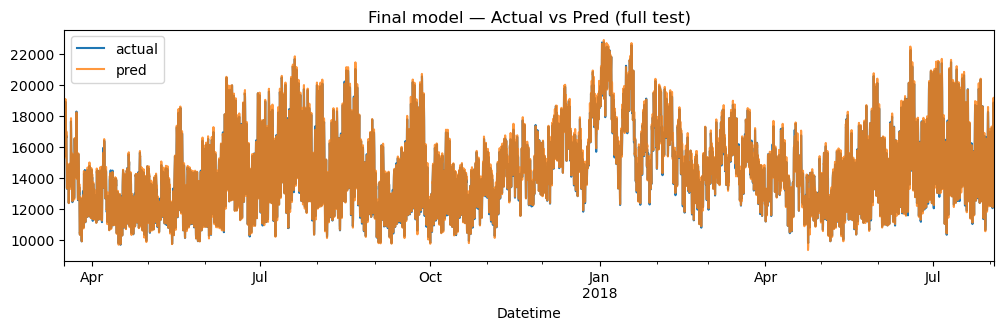

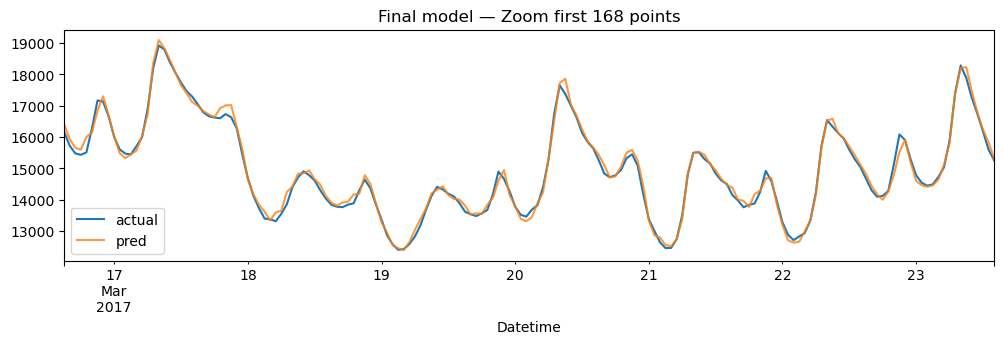

,actual,pred,abs_error
Datetime,,,
2017-03-16 15:00:00,16167.0,16417.679688,250.679688
2017-03-16 16:00:00,15723.0,15935.184570,212.184570
2017-03-16 17:00:00,15476.0,15654.728516,178.728516
2017-03-16 18:00:00,15429.0,15594.483398,165.483398
2017-03-16 19:00:00,15505.0,16002.306641,497.306641
2017-03-16 20:00:00,16268.0,16134.871094,133.128906
2017-03-16 21:00:00,17166.0,16843.029297,322.970703
2017-03-16 22:00:00,17132.0,17300.376953,168.376953
2017-03-16 23:00:00,16660.0,16684.925781,24.925781


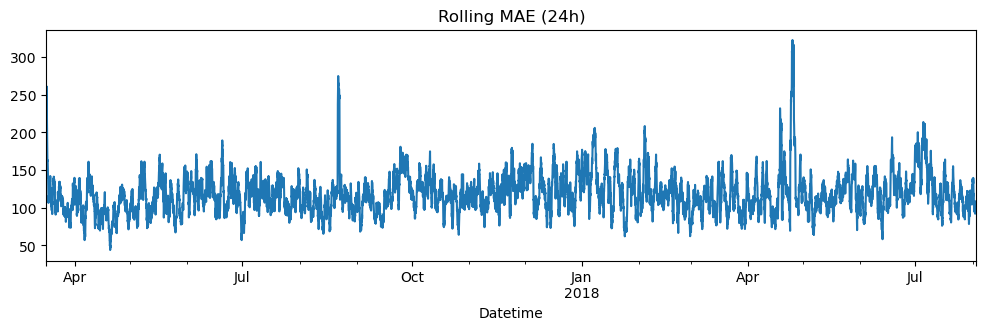

In [ ]:
# evaluate final model on the untouched test set and show diagnostics
from electricity_forecast_utils import invert_and_eval
import pandas as pd
import matplotlib.pyplot as plt

# predict (scaled) and invert
y_test_pred_scaled = model_final.predict(X_test).reshape(-1)
y_test_true_scaled = y_test.reshape(-1)

y_true, y_pred, mae_final, rmse_final = invert_and_eval(y_test_true_scaled, y_test_pred_scaled, scaler)
print(f"FINAL TEST MAE:  {mae_final:.3f}")
print(f"FINAL TEST RMSE: {rmse_final:.3f}")

# make a small DataFrame for plots (try to align timestamps if possible)
try:
    test_idx = test_series.index[window_size + (horizon - 1):][: len(y_true)]
except Exception:
    test_idx = pd.RangeIndex(start=0, stop=len(y_true))

df_test = pd.DataFrame({"actual": y_true, "pred": y_pred}, index=test_idx)

# full plot
plt.figure(figsize=(12,3))
df_test['actual'].plot(label='actual')
df_test['pred'].plot(label='pred', alpha=0.8)
plt.legend(); plt.title("Final model — Actual vs Pred (full test)"); plt.show()

# zoom (first week)
zoom_n = min(len(df_test), 24*7)
plt.figure(figsize=(12,3))
df_test.iloc[:zoom_n]['actual'].plot(label='actual')
df_test.iloc[:zoom_n]['pred'].plot(label='pred', alpha=0.8)
plt.legend(); plt.title(f"Final model — Zoom first {zoom_n} points"); plt.show()

# small sample table and rolling MAE
display(df_test.head(12).assign(abs_error=lambda d: (d['pred']-d['actual']).abs()))
errors = df_test['pred'] - df_test['actual']
rolling_mae = errors.abs().rolling(window=24, min_periods=1).mean()
plt.figure(figsize=(12,3)); rolling_mae.plot(); plt.title('Rolling MAE (24h)'); plt.show()

# Optional models below

In [ ]:
# multi-step windowing (direct forecasting)
def make_windows_multistep(arr, w, horizon):
    X, y = [], []
    max_start = len(arr) - w - horizon
    for i in range(max_start):
        X.append(arr[i:i+w])
        y.append(arr[i+w:i+w+horizon])  # target is a sequence of length horizon
    return np.array(X).reshape(-1, w, 1), np.array(y)

# choose horizon (e.g., next 24 hours)
horizon = 24

# scale train, val, test exactly like before
train_scaled = scaler.fit_transform(train_series.values.reshape(-1,1)).reshape(-1)
val_scaled   = scaler.transform(val_series.values.reshape(-1,1)).reshape(-1)
test_scaled  = scaler.transform(test_series.values.reshape(-1,1)).reshape(-1)

# build the multi-step windows
X_train_m, y_train_m = make_windows_multistep(train_scaled, window_size, horizon)
X_val_m,   y_val_m   = make_windows_multistep(val_scaled,   window_size, horizon)
X_test_m,  y_test_m  = make_windows_multistep(test_scaled,  window_size, horizon)

print("multi-step shapes:")
print(" X_train_m:", X_train_m.shape)
print(" X_val_m:  ", X_val_m.shape)
print(" X_test_m: ", X_test_m.shape)
print(" y target shape (should be horizon):", y_train_m.shape[1])

multi-step shapes:
 X_train_m: (96988, 24, 1)
 X_val_m:   (12082, 24, 1)
 X_test_m:  (12082, 24, 1)
 y target shape (should be horizon): 24


# Builds and trains multi-step LSTM model.

In [ ]:
# LSTM model for multi-step forecasting
from tensorflow.keras import layers
from tensorflow import keras

def build_multistep_model(input_shape, units=64, dropout=0.1, lr=1e-3, horizon=24):
    model = keras.Sequential()
    model.add(layers.LSTM(units, input_shape=input_shape))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(horizon))  # predict next horizon steps at once
    model.compile(optimizer=keras.optimizers.Adam(lr),
                  loss="mse",
                  metrics=["mae"])
    return model

model_ms = build_multistep_model(
    input_shape=(window_size, 1),
    units=best_hp.values["units"],     # reuse tuned values
    dropout=best_hp.values["dropout"],
    lr=best_hp.values["lr"],
    horizon=horizon
)

history_ms = model_ms.fit(
    X_train_m, y_train_m,
    validation_data=(X_val_m, y_val_m),
    epochs=20,
    batch_size=64,
    verbose=2
)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1516/1516 - 17s - 11ms/step - loss: 0.0073 - mae: 0.0597 - val_loss: 0.0038 - val_mae: 0.0469
Epoch 2/20
1516/1516 - 15s - 10ms/step - loss: 0.0041 - mae: 0.0477 - val_loss: 0.0037 - val_mae: 0.0458
Epoch 3/20
1516/1516 - 18s - 12ms/step - loss: 0.0036 - mae: 0.0448 - val_loss: 0.0033 - val_mae: 0.0428
Epoch 4/20
1516/1516 - 16s - 11ms/step - loss: 0.0033 - mae: 0.0428 - val_loss: 0.0032 - val_mae: 0.0423
Epoch 5/20
1516/1516 - 17s - 11ms/step - loss: 0.0031 - mae: 0.0413 - val_loss: 0.0033 - val_mae: 0.0423
Epoch 6/20
1516/1516 - 15s - 10ms/step - loss: 0.0030 - mae: 0.0400 - val_loss: 0.0029 - val_mae: 0.0394
Epoch 7/20
1516/1516 - 15s - 10ms/step - loss: 0.0028 - mae: 0.0390 - val_loss: 0.0033 - val_mae: 0.0414
Epoch 8/20
1516/1516 - 14s - 9ms/step - loss: 0.0027 - mae: 0.0382 - val_loss: 0.0028 - val_mae: 0.0389
Epoch 9/20
1516/1516 - 18s - 12ms/step - loss: 0.0026 - mae: 0.0373 - val_loss: 0.0029 - val_mae: 0.0391
Epoch 10/20
1516/1516 - 16s - 10ms/step - loss: 0.0025 - mae: 0.036

# Evaluates multi-step predictions and visualizes forecast.

378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Average MAE across all 24 steps: 590.677709412655
Average RMSE across all 24 steps: 779.948210143352


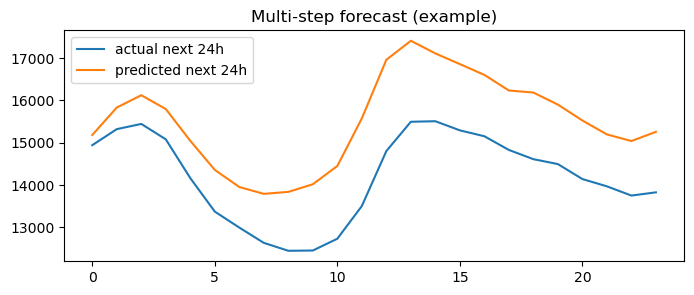

In [ ]:
# evaluating multi-step forecasts (predict 24 hours ahead)
y_pred_scaled = model_ms.predict(X_test_m)

# inverse transform
y_true_ms = scaler.inverse_transform(y_test_m)
y_pred_ms = scaler.inverse_transform(y_pred_scaled)

# compute errors step-by-step
mae_per_step = np.mean(np.abs(y_true_ms - y_pred_ms), axis=0)
rmse_per_step = np.sqrt(np.mean((y_true_ms - y_pred_ms)**2, axis=0))

print("Average MAE across all 24 steps:", mae_per_step.mean())
print("Average RMSE across all 24 steps:", rmse_per_step.mean())

# plot forecast vs actual for one example
idx = 100
plt.figure(figsize=(8,3))
plt.plot(y_true_ms[idx], label="actual next 24h")
plt.plot(y_pred_ms[idx], label="predicted next 24h")
plt.legend()
plt.title("Multi-step forecast (example)")
plt.show()

# Prepares data inputs for Prophet model.

In [ ]:
# Diagnostic: check Prophet input frames before calling fit()
import pandas as pd
from pprint import pprint

# Build candidate df for Prophet from the cleaned 'df' (which has Datetime index and AEP_MW)
df_prophet = pd.DataFrame({"ds": df.index, "y": df["AEP_MW"].values})

# show global info
print("df_prophet shape:", df_prophet.shape)
print("non-null y:", df_prophet['y'].notnull().sum(), "null y:", df_prophet['y'].isna().sum())
print("ds dtype:", df_prophet['ds'].dtype)

# show the train/val/test split indices we used earlier (train_end, val_end)
try:
    print("train_end index int:", train_end, "val_end index int:", val_end)
except NameError:
    print("train_end / val_end not found in scope")

# show slices and their counts
try:
    df_train_prophet = df_prophet.iloc[:val_end]   # same selection used before
    df_test_prophet = df_prophet.iloc[val_end:val_end+200]
    print("df_train_prophet shape:", df_train_prophet.shape, "non-null y:", df_train_prophet['y'].notnull().sum())
    print("df_test_prophet shape:", df_test_prophet.shape, "non-null y:", df_test_prophet['y'].notnull().sum())
    print("\nFirst 5 rows of df_train_prophet:")
    display(df_train_prophet.head())
    print("\nLast 5 rows of df_train_prophet:")
    display(df_train_prophet.tail())
except Exception as e:
    print("Error when slicing df_prophet:", e)

df_prophet shape: (121296, 2)
non-null y: 121296 null y: 0
ds dtype: datetime64[ns]
train_end index int: 97036 val_end index int: 109166
df_train_prophet shape: (109166, 2) non-null y: 109166
df_test_prophet shape: (200, 2) non-null y: 200

First 5 rows of df_train_prophet:


,ds,y
0,2004-10-01 01:00:00,12379.0
1,2004-10-01 02:00:00,11935.0
2,2004-10-01 03:00:00,11692.0
3,2004-10-01 04:00:00,11597.0
4,2004-10-01 05:00:00,11681.0



Last 5 rows of df_train_prophet:


,ds,y
109161,2017-03-15 10:00:00,19920.0
109162,2017-03-15 11:00:00,19645.0
109163,2017-03-15 12:00:00,19118.0
109164,2017-03-15 13:00:00,18783.0
109165,2017-03-15 14:00:00,18398.0



# Fits Prophet model and evaluates performance.

In [ ]:
# Clean fit for Prophet using train+val period (train_end/val_end from earlier)
from prophet import Prophet

# build clean DataFrame for Prophet and drop NaNs
df_prophet = pd.DataFrame({"ds": df.index, "y": df["AEP_MW"].values})
df_prophet = df_prophet.dropna().reset_index(drop=True)

# define train slice explicitly (use previously computed train/val/test split indices)
train_slice = slice(0, val_end)   # train+val = up to val_end (exclusive)
df_train_prophet = df_prophet.iloc[train_slice]

print("Fitting Prophet on df_train_prophet with shape:", df_train_prophet.shape)
m = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)

# Fit (this may take a bit of time)
m.fit(df_train_prophet)

# Forecast the next N hours where N is the length of the test slice you want to evaluate
n_forecast = len(df_prophet) - val_end
future = m.make_future_dataframe(periods=n_forecast, freq="H")
forecast = m.predict(future)

# align and compute metrics on the same slice we used before
pred = forecast.iloc[-n_forecast:]["yhat"].values
actual = df_prophet.iloc[val_end:val_end + n_forecast]["y"].values

import numpy as np
mae_prophet = np.mean(np.abs(pred - actual))
rmse_prophet = np.sqrt(np.mean((pred - actual)**2))
print(f"Prophet MAE: {mae_prophet:.3f}, RMSE: {rmse_prophet:.3f}")

Fitting Prophet on df_train_prophet with shape: (109166, 2)


20:55:42 - cmdstanpy - INFO - Chain [1] start processing
20:56:05 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet MAE: 1406.780, RMSE: 1886.166



# Builds results comparison table across all models.

In [ ]:
# comparison table

import pandas as pd

results = pd.DataFrame([
    {
        "model": "Baseline LSTM (1-step)",
        "MAE": mae_test,               # from baseline evaluation block
        "RMSE": rmse_test
    },
    {
        "model": "Tuned LSTM (1-step)",
        "MAE": mae_final,              # from final tuned model eval
        "RMSE": rmse_final
    },
    {
        "model": f"LSTM ({horizon}-step horizon avg)",
        "MAE": mae_per_step.mean(),    # from multi-step LSTM block
        "RMSE": rmse_per_step.mean()
    },
    {
        "model": "Prophet baseline",
        "MAE": mae_prophet,            # from Prophet block
        "RMSE": rmse_prophet
    }
])

results.set_index("model", inplace=True)
display(results)

,MAE,RMSE
model,,
Baseline LSTM (1-step),122.473974,163.941348
Tuned LSTM (1-step),118.170087,158.140145
LSTM (24-step horizon avg),590.677709,779.948210
Prophet baseline,1406.779829,1886.165633


# Visualizes model comparison metrics in bar plot.

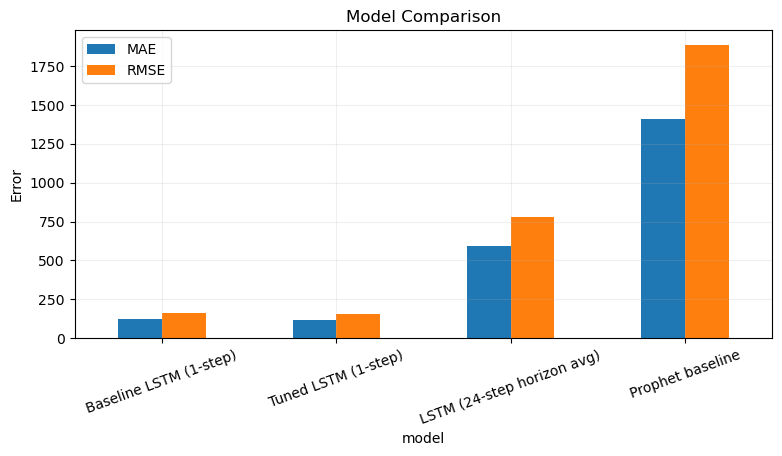

In [ ]:
results_plot = results.copy()

ax = results_plot[["MAE", "RMSE"]].plot(kind="bar", figsize=(9,4))
ax.set_ylabel("Error")
ax.set_title("Model Comparison")
plt.xticks(rotation=20)
plt.grid(alpha=0.2)
plt.show()